In [2]:
from scipy import stats

def est_poission_rate_ci(n_events, 
                         source_duration, 
                         target_duration=1.0, 
                         ci=0.99,
                         expected_avg_n_events_per_unit_duration=200):
    """
    Estimate poission rate parameter confidence interval

    Parameters
    ----------
    n_events : int
        number of observed events
    source_duration : float
        duration for which n_events were observed
    target_duration : float
        duration for which to return expected rate
    ci : float
        size of confidence interval

    Returns
    -------
    (float,float)
        Confidence interval left, right bounds
    """
    
    def calc_posterior(prior_shape, prior_scale, n_events, duration):
        posterior_shape = prior_shape + n_events
        posterior_scale = prior_scale/(prior_scale*duration+1)

        return posterior_shape, posterior_scale

    rate_prior_average = expected_avg_n_events_per_unit_duration
    rate_prior_shape = 1
    rate_prior_scale = rate_prior_average/rate_prior_shape
    rate_prior = stats.gamma(rate_prior_shape,scale=rate_prior_scale)
    
    posterior_shape, posterior_scale = calc_posterior(rate_prior_shape, 
                                                      rate_prior_scale, 
                                                      n_events, 
                                                      source_duration/target_duration)

    posterior = stats.gamma(posterior_shape,scale=posterior_scale)
    return posterior.interval(ci)
    

# Expecred ci vs act ci

In [3]:
def calc_true_ci(true_distr,expected_ci):
    """
    Calculate true confidence interval for given disribusion 'true_distr' 
    and expected conf. interval
    """
    n_trials = 500
    n_hits = 0
    for _ in range(n_trials):
        n_observed = true_distr.rvs()
        ci_left, ci_right = est_poission_rate_ci(n_observed,1,ci=expected_ci)

        #print(ci_left, ci_right)
        #print('########')
        n_hits += (ci_left <= true_rate <= ci_right)

        

    return n_hits/n_trials

In [4]:
# Collect data
import numpy as np

expected_cis = np.linspace(0.7,0.98,num=10)
true_cis = np.array([ calc_true_ci(true_distr,ci) for ci in expected_cis ])


NameError: name 'true_distr' is not defined

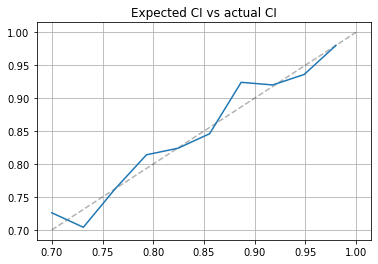

In [202]:
# Plot
from matplotlib.pyplot import plot, grid, title

title("Expected CI vs actual CI")
plot([0.7,1],[0.7,1],ls='--',color='k',alpha=0.3)
plot(expected_cis,true_cis)
grid(True)

# Testing

In [14]:
%load_ext google.cloud.bigquery


The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import pandas as pd 

In [65]:
%%bigquery df
with temp_tab as (
  SELECT  date(t.booked_at) as booking_date, 
          extract(hour from t.booked_at) as booking_hour, 
          sum(t.tickets_pax) as pax
  FROM `distribusion-next-13.dl_analytics_v_0_2.bookings_caramelo` t
  where t.retailer_name in ('Omio')
        and date(t.booked_at ) >= '2021-10-01'
        and date(t.booked_at ) <= '2021-11-30'
  group by booking_date, booking_hour
  order by booking_date, booking_hour
)

select t1.*, t2.pax as expected_pax_w1, t3.pax as expected_pax_w2, t4.pax as expected_pax_w3
from temp_tab t1 
left join temp_tab t2
on t1.booking_date = date_add(t2.booking_date, interval 7 day)
   and t1.booking_hour = t2.booking_hour
left join temp_tab t3
on t1.booking_date = date_add(t3.booking_date, interval 14 day)
   and t1.booking_hour = t3.booking_hour
left join temp_tab t4
on t1.booking_date = date_add(t4.booking_date, interval 21 day)
   and t1.booking_hour = t4.booking_hour
where t1.booking_date >= '2021-11-01'
order by t1.booking_date, t1.booking_hour

Downloading: 100%|██████████| 718/718 [00:01<00:00, 377.16rows/s]


In [66]:
df.head()

,booking_date,booking_hour,pax,expected_pax_w1,expected_pax_w2,expected_pax_w3
0,2021-11-01,0,21,27.0,16.0,18.0
1,2021-11-01,1,7,13.0,21.0,6.0
2,2021-11-01,2,11,7.0,8.0,5.0
3,2021-11-01,3,9,12.0,5.0,13.0
4,2021-11-01,4,8,10.0,12.0,12.0


In [60]:
def desp(pax):

    """
    Estimate expected rate parameter 

    Parameters
    ----------
    pax : DataFrame
        Pax to forecast 

    Returns
    -------
    (array,array)
        pax prediction, pax groundtruth
    """

    alphas = [0.496]
    t = 24
    sqt_prev = 0
    sqt2_prev = 0
    for alpha in alphas: 
        prediction_result = []
        for p in pax:
            f = alpha * t / (1 - alpha)
            sqt_x = (alpha * p) + ((1 - alpha) * sqt_prev)
            sqt2_x = (alpha * sqt_x) + ((1 - alpha) * sqt2_prev)
            pred_x = (2 + f) * sqt_x - (1 + f) * sqt2_x
            if pred_x < 0:
                result = 0 
            else:
                result = np.array(pred_x)
            sqt_prev = np.array(sqt_x)
            sqt2_prev = np.array(sqt2_x)
            prediction_result.append(result)  

    dataset_pred = np.array(prediction_result)
    dataset_true = pax
    return dataset_pred, dataset_true


def compute_metrics(true_data, preds_data):

    """
    Computes metrics for performance evaluation

    Parameters
    ----------
    true_data : array
        original time series received from "desp function" 

    preds_data : array
        prediction time series received from "desp function" 

    Returns
    -------
    (int,int)
        mae, rmse
    """

    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(true_data, preds_data)
    # Root Mean Squared Error (RMSE)
    rmse = sqrt(mean_squared_error(true_data, preds_data))
    return mae, rmse

In [61]:
3

In [62]:
outlier, df_result, final = runner(df)
outlier_df = pd.DataFrame(outlier, columns= ['booking_date',
                                            'booking_hour', 
                                            'n_actual_events',
                                            'rate_ci_l', 
                                            'rate_ci_r',
                                            'expected_rate'])

final_df = pd.DataFrame(final, columns= ['booking_date',
                                            'booking_hour', 
                                            'n_actual_events',
                                            'rate_ci_l', 
                                            'rate_ci_r',
                                            'expected_rate'])

print('In total we found: ' + str(len(outlier)) + ' outlier.')


MAE is : 6.965336048857531
RMSE is : 8.588727133067152
----
In total we found: 145 outlier.


In [34]:
final_df[669:669+26]

,booking_date,booking_hour,n_actual_events,rate_ci_l,rate_ci_r,expected_rate
669,2021-11-28,23,105,80.954280,133.725125,94.062374
670,2021-11-29,0,37,23.878873,55.470340,34.657929
671,2021-11-29,1,21,11.733181,35.767438,4.272437
672,2021-11-29,2,33,20.752969,50.634788,12.573284
673,2021-11-29,3,11,4.918524,22.665926,0.000000
674,2021-11-29,4,6,2.027201,15.581766,0.000000
675,2021-11-29,5,25,14.667246,40.796431,13.219720
676,2021-11-29,6,27,16.164421,43.280475,23.385685
677,2021-11-29,7,27,16.164421,43.280475,26.857183
678,2021-11-29,8,80,59.399105,105.527886,80.350134


<AxesSubplot:>

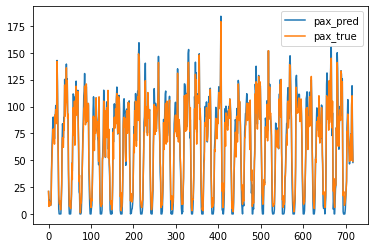

In [105]:
df_result.plot()

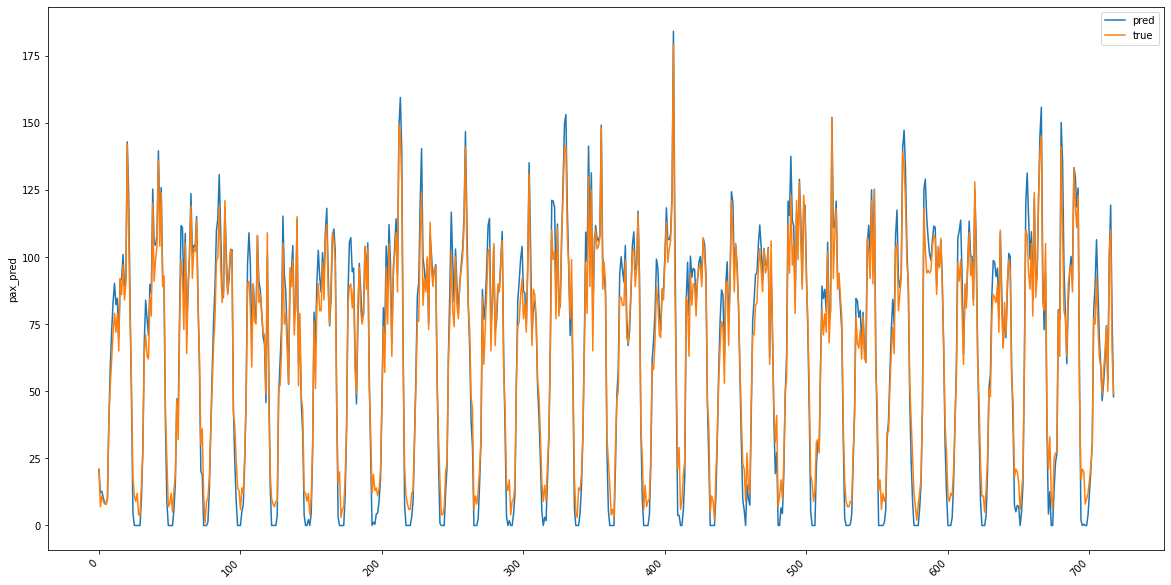

In [35]:
from datetime import datetime
import numpy as np
from numpy import hstack
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.dates as mdates



plt.figure(figsize=(20,10))

ax = sns.lineplot(data=df_result, y='pax_pred', x= df_result.index, label = 'pred')
ax = sns.lineplot(data=df_result, y='pax_true', x= df_result.index, label = 'true')


plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light')

plt.show()

In [36]:
final = df.merge(outlier_df , how = 'outer' )
final[660:]

,booking_date,booking_hour,pax,expected_pax_w1,expected_pax_w2,n_actual_events,rate_ci_l,rate_ci_r,expected_rate
660,2021-11-28,14,78,79.0,78.0,NaN,NaN,NaN,NaN
661,2021-11-28,15,124,121.0,83.0,NaN,NaN,NaN,NaN
662,2021-11-28,16,85,99.0,109.0,NaN,NaN,NaN,NaN
663,2021-11-28,17,93,128.0,123.0,NaN,NaN,NaN,NaN
664,2021-11-28,18,122,107.0,141.0,NaN,NaN,NaN,NaN
665,2021-11-28,19,139,88.0,141.0,NaN,NaN,NaN,NaN
666,2021-11-28,20,145,123.0,108.0,NaN,NaN,NaN,NaN
667,2021-11-28,21,83,116.0,97.0,NaN,NaN,NaN,NaN
668,2021-11-28,22,80,91.0,77.0,NaN,NaN,NaN,NaN
669,2021-11-28,23,105,76.0,99.0,NaN,NaN,NaN,NaN


<AxesSubplot:>

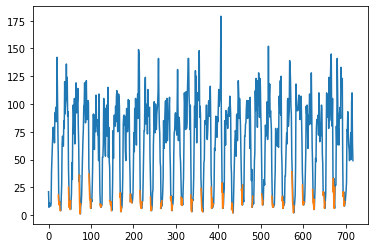

In [70]:
final['pax'].plot()
final['n_actual_events'].plot()

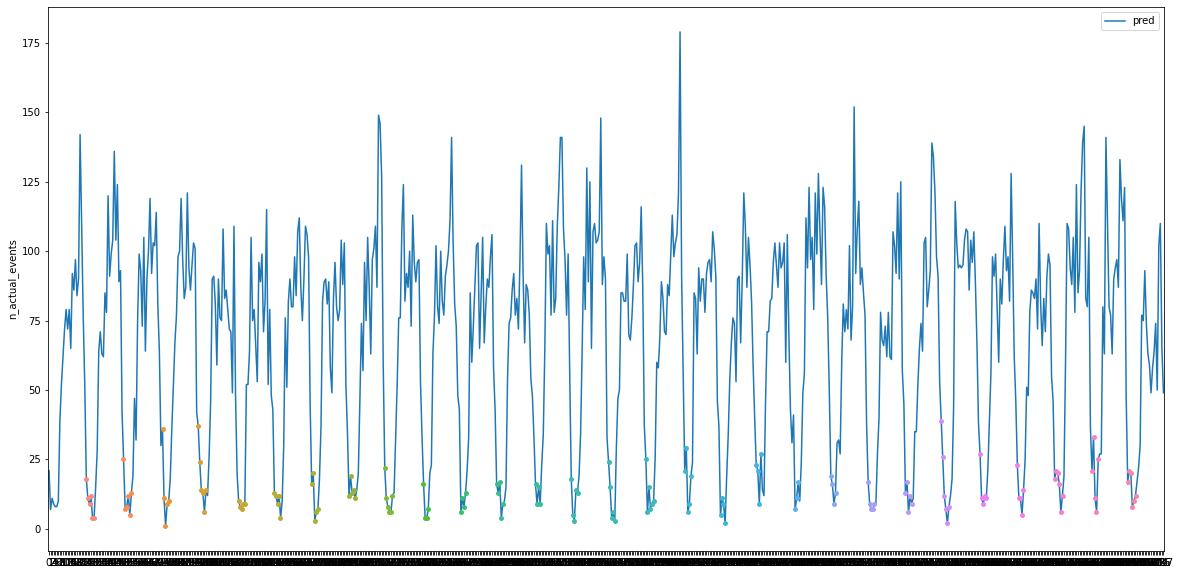

In [37]:
plt.figure(figsize=(20,10))

ax = sns.lineplot(data=final, y='pax', x= final.index , label = 'pred')
ax = sns.stripplot(data=final, y='n_actual_events', x= final.index , label = 'outlier')


plt.show()

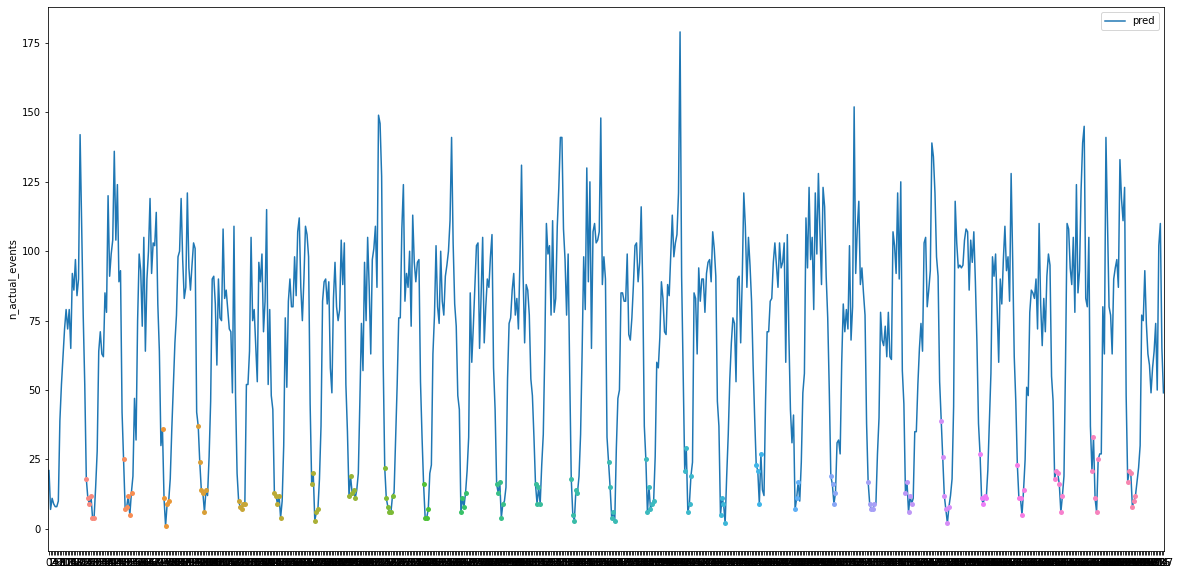

In [38]:
plt.figure(figsize=(20,10))

ax = sns.lineplot(data=final, y='pax', x= final.index , label = 'pred')
ax = sns.stripplot(data=final, y='n_actual_events', x= final.index , label = 'outlier')


plt.show()

In [414]:
df_n_actual_events[24:44]

24     18
25     11
26      9
27     12
28      4
29      4
30     15
31     28
32     64
33     71
34     63
35     62
36     85
37     78
38    120
39     91
40     99
41    104
42    136
43    104
Name: pax, dtype: int64